In [45]:
!gdown https://drive.google.com/uc?id=1K4APdA6GUhS57kS6YGMYIU8QhFMHSDLd
!unzip -q ModMonuSeg.zip

Downloading...
From: https://drive.google.com/uc?id=1K4APdA6GUhS57kS6YGMYIU8QhFMHSDLd
To: /content/ModMonuSeg.zip
224MB [00:05, 40.9MB/s]


In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from ConfigFile import Config
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import backend as K

In [0]:
class Unet():
  def __init__(self):
    self.image_width = 256
    self.image_height = 256

  def load_Images(self,parent_dir, im_shape, img_folder="TissueImages/", gt_folder="GroundTruth/", gt_extension=None):
    tissue_dir = parent_dir + img_folder
    gt_dir = parent_dir + gt_folder

    self.image_width, self.image_height = im_shape


    ids = next(os.walk(tissue_dir))[2]
    print("No. of images = ", len(ids))

    X = np.zeros((len(ids), self.image_height, self.image_width, 3), dtype=np.float32)
    y = np.zeros((len(ids), self.image_height, self.image_width, 1), dtype=np.float32)

    # tqdm is used to display the progress bar
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
      # Load images
      img = load_img(tissue_dir+id_)
      x_img = img_to_array(img)
      x_img = resize(x_img, (self.image_width, self.image_height, 3), mode = 'constant', preserve_range = True)
      # Load masks
      mask_id_ = id_.split('.')[0]
      mask_id_ = '-'.join(id_.split('-')[:-1]) + '_bin_mask-'+ id_.split('-')[-1]
      if gt_extension:
        mask_id_ = mask_id_.split('.')[0] + '.' + gt_extension
      mask = img_to_array(load_img(gt_dir+mask_id_, grayscale=True))
      mask = resize(mask, (self.image_width, self.image_height, 1), mode = 'constant', preserve_range = True)
      # Save images
      X[n] = x_img/255.0
      y[n] = mask/255.0

    return X, y

  # Define Some metrics
  ## Dice Score
  def dice_coefficient(self,y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

  def recall(self,y_true, y_pred):
      """Recall metric.

      Only computes a batch-wise average of recall.

      Computes the recall, a metric for multi-label classification of
      how many relevant items are selected.
      """
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
      recall = true_positives / (possible_positives + K.epsilon())
      return recall

  def precision(self,y_true, y_pred):
      """Precision metric.

      Only computes a batch-wise average of precision.

      Computes the precision, a metric for multi-label classification of
      how many selected items are relevant.
      """
      true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
      predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
      precision = true_positives / (predicted_positives + K.epsilon())
      return precision

  def conv2d_Block(self,input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

  def buildUnet_Architecture(self,input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = self.conv2d_Block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = self.conv2d_Block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = self.conv2d_Block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = self.conv2d_Block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = self.conv2d_Block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    d6 = tf.keras.layers.SpatialDropout2D(0.3)(c5)
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(d6)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = self.conv2d_Block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = self.conv2d_Block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = self.conv2d_Block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = self.conv2d_Block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

  def plot_sample(self,X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Input')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground Truth')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Predicted binary');

  ## F1 Score
  def f1_score(self,y_true, y_pred):
    presi = self.precision(y_true, y_pred)
    recall = self.recall(y_true, y_pred)
    return 2*((presi*recall)/(presi+recall+K.epsilon()))

  # Plot the learning curve
  def curve_plot(self,results):
    plt.figure(figsize=(8, 8))
    plt.title("Learning curve")
    plt.plot(results.history["loss"], label="loss")
    plt.plot(results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();

In [60]:
config = Config()
unet_instance = Unet()
X, y = unet_instance.load_Images(config.train_parent_dir, (config.im_width, config.im_height),config.img_folder, config.gt_folder, config.train_gt_extension)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

No. of images =  1080


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
input_image = Input((None, None, 3), name='img')
model = unet_instance.buildUnet_Architecture(input_image, n_filters=18, dropout=0.06, batchnorm=True)
model.compile(optimizer=config.optimizer, loss="binary_crossentropy", metrics=["accuracy", unet_instance.dice_coefficient, unet_instance.f1_score])

In [62]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, None, None, 1 504         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_91 (BatchNo (None, None, None, 1 72          conv2d_96[0][0]                  
__________________________________________________________________________________________________
activation_91 (Activation)      (None, None, None, 1 0           batch_normalization_91[0][0]     
____________________________________________________________________________________________

In [63]:
history = model.fit(X_train, y_train, batch_size=config.batch_size, epochs=config.epochs, callbacks=config.callbacks,
                    validation_data=(X_valid, y_valid))

Epoch 1/50
16/16 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.8119 - dice_coefficient: 0.5006 - f1_score: 0.6060
Epoch 00001: val_loss improved from inf to 1.04217, saving model to unet-model.h5
16/16 [==============================] - 7s 417ms/step - loss: 0.4138 - accuracy: 0.8119 - dice_coefficient: 0.5006 - f1_score: 0.6060 - val_loss: 1.0422 - val_accuracy: 0.7267 - val_dice_coefficient: 0.0859 - val_f1_score: 9.5314e-06 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - ETA: 0s - loss: 0.3124 - accuracy: 0.8686 - dice_coefficient: 0.6424 - f1_score: 0.7631
Epoch 00002: val_loss improved from 1.04217 to 0.56689, saving model to unet-model.h5
16/16 [==============================] - 5s 328ms/step - loss: 0.3124 - accuracy: 0.8686 - dice_coefficient: 0.6424 - f1_score: 0.7631 - val_loss: 0.5669 - val_accuracy: 0.7384 - val_dice_coefficient: 0.3138 - val_f1_score: 0.2046 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - ETA: 0s 

#Learning Curve plot

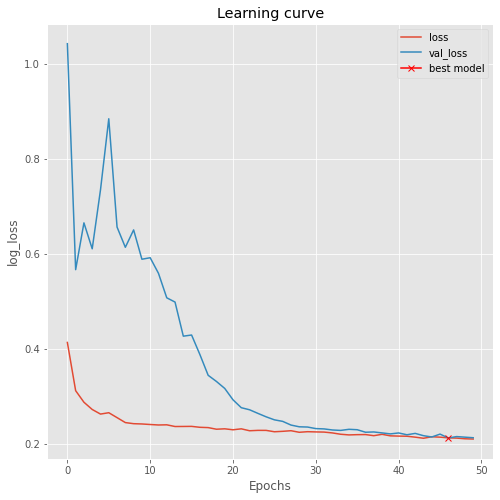

In [67]:
unet_instance.curve_plot(history)

##Evaluation##
 **on validation set**

In [68]:
X_test, y_test = unet_instance.load_Images(config.test_parent_dir, (config.im_width, config.im_height),
                  config.img_folder, config.gt_folder, config.test_gt_extension)
model.evaluate(X_test, y_test, verbose=1)

No. of images =  504


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '



16/16 [==============================] - 1s 73ms/step - loss: 0.2188 - accuracy: 0.9069 - dice_coefficient: 0.7044 - f1_score: 0.7701


[0.21877214312553406,
 0.9069372415542603,
 0.7044232487678528,
 0.7700559496879578]

# Predict on train, val and test

In [69]:
preds = model.predict(X_test, verbose=1)
preds_t = (preds > 0.5).astype(np.uint8)

16/16 [==============================] - 1s 56ms/step


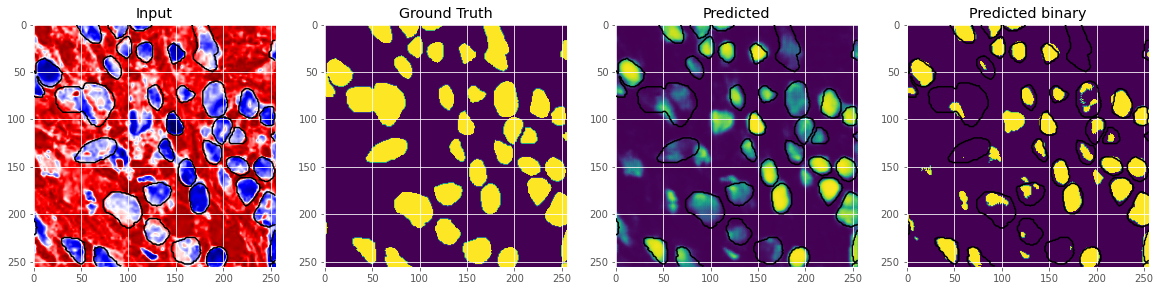

In [70]:
# Check if training data looks all right
unet_instance.plot_sample(X_test, y_test, preds, preds_t)

#Model Graph Plotting

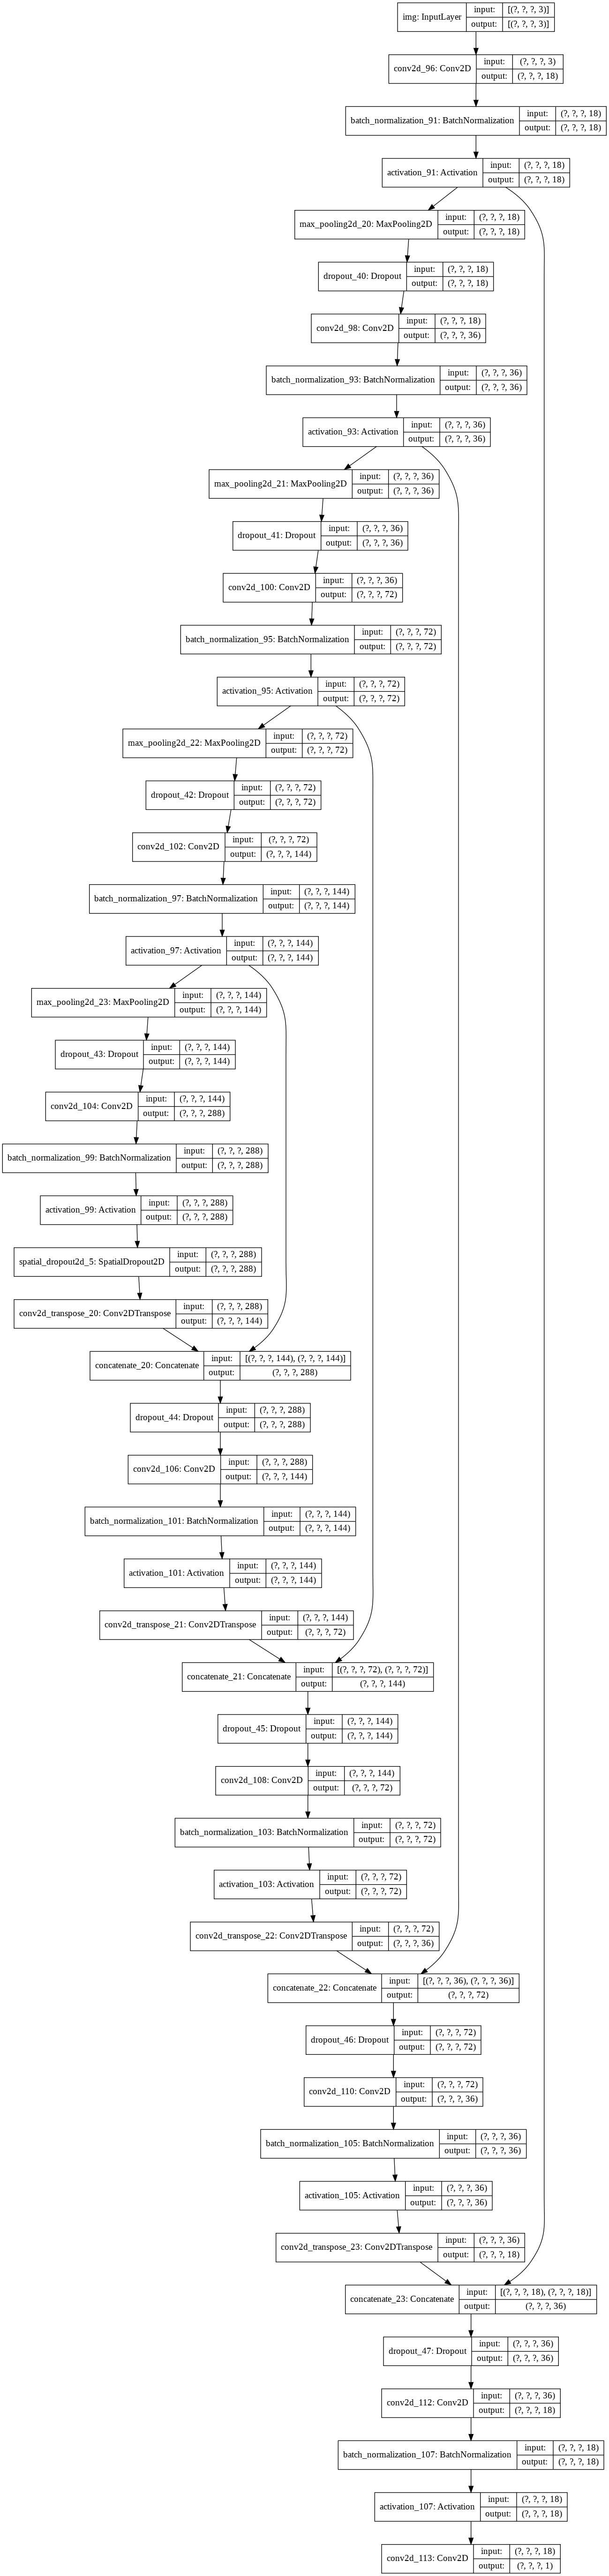

In [71]:
from tensorflow.keras.utils import plot_model
# Plot model graph
plot_model(model, show_shapes=True, show_layer_names=True, to_file='unetModel.png')
from IPython.display import Image
Image(retina=True, filename='unetModel.png')